# Cleaned vs Dirty

<img src="images/plate.jpg">

<div class="sc-gpSXuZ cnEYjn"><div id="Description" class="sc-dtiVSR jTGhFH"><div class="sc-cYnRcR AGcYs"><div class="sc-hkcRYQ cLSyxq"><div class="sc-tSpkn bmHgvF"><h3 class="sc-cBYhjr sc-eFHqgm cMAYca uePtT">Description</h3><div class="sc-ezTrPE cWBTpb"><p>Hi! It is boring to wash the dishes. Luckily, half of them are already clean. Train a classifier to determine clean ones to save time for the new machine learning course ;)</p>
<p>It is a few shot learning competition. We have a dataset of <strong>20 clean</strong> and <strong>20 dirty</strong> plates in <strong>train</strong> and <strong>hundreds of plates in test</strong>. Good luck!</p></div></div></div>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zafermesutblen","key":"995425ec3b85ccd5b3968c2fab0c6f1b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle competitions download -c platesv2

100% 47.0M/47.0M [00:03<00:00, 18.0MB/s]
100% 47.0M/47.0M [00:03<00:00, 15.8MB/s]


In [ ]:
!unzip plates.zip

unzip:  cannot find or open plates.zip, plates.zip.zip or plates.zip.ZIP.


In [ ]:
!unzip platesv2.zip

Archive:  platesv2.zip
  inflating: plates.zip              
  inflating: sample_submission.csv   


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
img_rows, img_cols = 224, 224
batch_size = 64

n_epochs = 5
n_classes = 2
validation_split = 0.2
verbosity = 1


path_train = "/content/plates/train/"
path_test = "/content/plates/"

input_shape = (img_rows, img_cols, 3)

labels = ['cleaned', 'dirty']

seed = 10

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split = validation_split,
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    validation_split = validation_split,
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory = path_train,
    classes = labels,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'training'
)

validation_generator = validation_datagen.flow_from_directory(
    directory = path_train,
    classes = labels,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = ["test"],
    batch_size = 1,
    class_mode=None,
    shuffle = False,
    target_size=(img_rows, img_rows)
)


Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 744 images belonging to 1 classes.


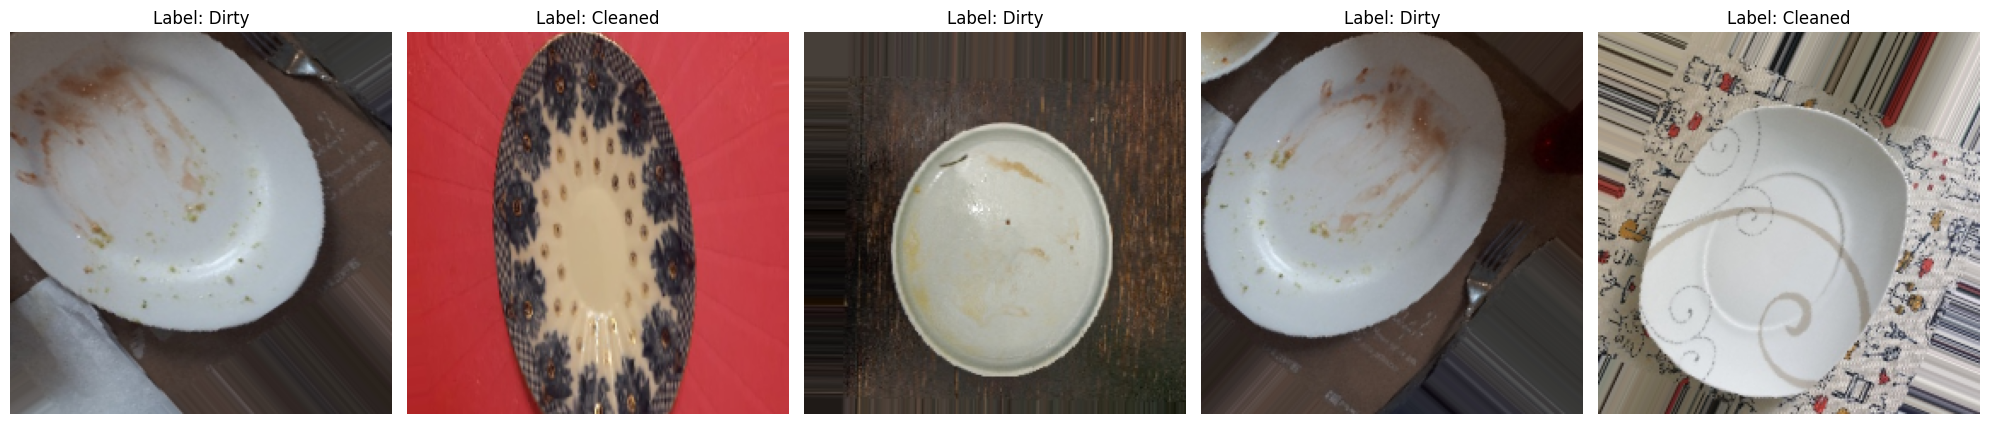

In [ ]:
random_indices = np.random.randint(len(train_generator), size=5)

plt.figure(figsize=(20, 10))
for i, rand_idx in enumerate(random_indices):
    batch = train_generator[rand_idx]
    images = batch[0]
    labels = batch[1]

    num_images_in_batch = images.shape[0]

    img_idx = np.random.randint(num_images_in_batch)

    plt.subplot(1, 5, i + 1)
    plt.imshow(images[img_idx])
    plt.title('Label: {}'.format('Cleaned' if labels[img_idx] == 0 else 'Dirty'))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from matplotlib import gridspec

import tensorflow as tf
from tensorflow.keras import optimizers
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import glob
from sklearn.utils import shuffle

In [ ]:
basemodel = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in basemodel.layers:
    layer.trainable = False


# Build the model
model = Sequential()
model.add(basemodel)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

In [ ]:
model.save('model.keras')

Minimum validation loss: 1.3930964469909668


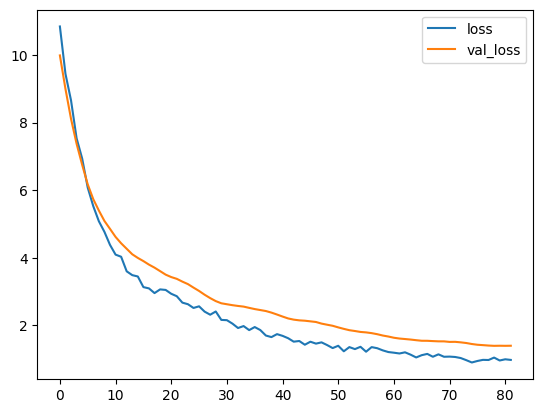

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

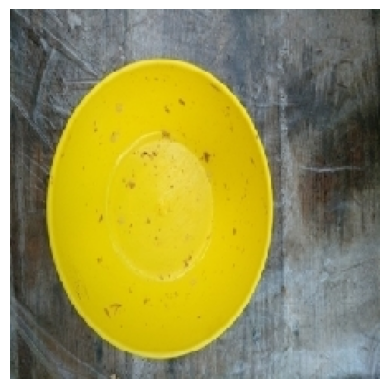

Prediction for custom image: dirty


In [ ]:


# Assuming your image dimensions
IMG_DIM = (224, 224)

# Read in all O and R test images file paths. Shuffle and select 50 random test images.
test_files = glob.glob('plates/test/*.jpg')  # Adjust file extension as per your image format
test_files = shuffle(test_files)[:50]  # Shuffle and select 50 random images

# Extract images and labels
test_imgs = []
test_labels = []

for img in test_files:
    # Load and resize image
    img_array = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM))
    test_imgs.append(img_array)

# Convert lists to numpy arrays
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

# Standardize
test_imgs_scaled = test_imgs.astype('float32') / 255.0

# Define functions for label conversion
def class2num(label):
    return 0 if label == 'cleaned' else 1

def num2class(num):
    return 'cleaned' if num < 0.5 else 'dirty'

# Convert labels to numerical format for model training
test_labels_enc = np.array([class2num(label) for label in test_labels])

# Load or define your model
# model = tf.keras.models.load_model('path_to_your_model.h5')  # Make sure to load your model if it's not defined

# Predict using the model
predictions_model_history = model.predict(test_imgs_scaled, verbose=0)

# Convert predictions from probabilities to class labels
predictions_model_labels = np.array([num2class(pred[0]) for pred in predictions_model_history])

# Example of predicting on a single custom image
custom_im = test_imgs_scaled[2]  # Assuming index 2 is a valid index in your test set

plt.imshow(custom_im)
plt.axis('off')
plt.show()

# Reshape and predict with the model
custom_im = custom_im.reshape((1, IMG_DIM[0], IMG_DIM[1], 3))  # Reshape to match model input shape
prediction_custom_im = model.predict(custom_im, verbose=0)

# If predictions are probabilities, use the following line
print(f"Prediction for custom image: {num2class(prediction_custom_im[0][0])}")



In [ ]:
preds = model.predict(test_generator, verbose=True)
labels = ['dirty' if x > 0.5 else 'cleaned' for x in preds]
submission_df = pd.read_csv('sample_submission.csv')
submission_df['label'] = labels

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


744/744 ━━━━━━━━━━━━━━━━━━━━ 454s 610ms/step


In [ ]:
submission_df

,id,label
0,0,dirty
1,1,dirty
2,2,cleaned
3,3,dirty
4,4,dirty
...,...,...
739,739,dirty
740,740,dirty
741,741,cleaned
742,742,dirty


In [ ]:
submission_df.to_csv('submission.csv', index=False)